In [38]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [83]:
# import the required plotting libraries

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


In [39]:
url = 'https://raw.githubusercontent.com/datameet/Municipal_Spatial_Data/master/Bangalore/BBMP.GeoJSON'
blore_json = requests.get(url).json()
blore_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'ASS_CONST_': '150',
    'ASS_CONST1': 'Yelahanka',
    'WARD_NO': 2.0,
    'WARD_NAME': 'Chowdeswari Ward',
    'POP_M': 10402.0,
    'POP_F': 9224.0,
    'POP_SC': 2630.0,
    'POP_ST': 286.0,
    'POP_TOTAL': 19626.0,
    'AREA_SQ_KM': 7.06,
    'LAT': 13.121709445639,
    'LON': 77.58042209477,
    'RESERVATIO': 'General'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[77.59229387222348, 13.097196193805827],
       [77.5909446804082, 13.09842185670555],
       [77.58908003112553, 13.100056732116494],
       [77.58733089155656, 13.101374720028643],
       [77.5871201872105, 13.101557392381482],
       [77.58690433786334, 13.101726651221453],
       [77.58651391149253, 13.1020326990065],
       [77.5859111620258, 13.102505182299376],
       [77.5850651716457, 13.103173181310986],
    

In [66]:
neighborhoods_data = blore_json['features']
neighborhoods_data[0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'ASS_CONST_': '150',
  'ASS_CONST1': 'Yelahanka',
  'WARD_NO': 2.0,
  'WARD_NAME': 'Chowdeswari Ward',
  'POP_M': 10402.0,
  'POP_F': 9224.0,
  'POP_SC': 2630.0,
  'POP_ST': 286.0,
  'POP_TOTAL': 19626.0,
  'AREA_SQ_KM': 7.06,
  'LAT': 13.121709445639,
  'LON': 77.58042209477,
  'RESERVATIO': 'General'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[77.59229387222348, 13.097196193805827],
     [77.5909446804082, 13.09842185670555],
     [77.58908003112553, 13.100056732116494],
     [77.58733089155656, 13.101374720028643],
     [77.5871201872105, 13.101557392381482],
     [77.58690433786334, 13.101726651221453],
     [77.58651391149253, 13.1020326990065],
     [77.5859111620258, 13.102505182299376],
     [77.5850651716457, 13.103173181310986],
     [77.58410452699253, 13.104024083555247],
     [77.58319712236873, 13.104900415224554],
     [77.5825264168394, 13.10561339006328],
     [77.58183549579502, 13.106420037985492],

In [73]:
# define the dataframe columns
column_names = ['Neighborhood', 'Ward', 'AreaSqKM', 'Population', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods.head()

Empty DataFrame
Columns: [Neighborhood, Ward, AreaSqKM, Population, Latitude, Longitude]
Index: []

In [74]:
for data in neighborhoods_data:
    neighborhood = data['properties']['ASS_CONST1']
    ward = data['properties']['WARD_NAME']
    areasqkm = data['properties']['AREA_SQ_KM']
    lat = data['properties']['LAT']
    lon = data['properties']['LON']
    pop = data['properties']['POP_TOTAL']
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood, 
                                            'Ward': ward,
                                            'AreaSqKM': areasqkm,
                                            'Population': pop,
                                            'Latitude': lat,
                                            'Longitude': lon}, ignore_index=True)
neighborhoods['PopDensity'] = neighborhoods['Population']/neighborhoods['AreaSqKM']



In [75]:
neighborhoods.loc[neighborhoods['Neighborhood'] == 'Yelahanka']


Neighborhood                      Ward  AreaSqKM  Population   Latitude  \
0      Yelahanka          Chowdeswari Ward      7.06     19626.0  13.121709   
1      Yelahanka                    Atturu     10.15     24020.0  13.102805   
2      Yelahanka  Yelahanka Satellite Town      4.90     25782.0  13.090987   
185    Yelahanka           Kempegowda Ward     10.47     21866.0  13.116188   

     Longitude   PopDensity  
0    77.580422  2779.886686  
1    77.560038  2366.502463  
2    77.583925  5261.632653  
185  77.599713  2088.443171

In [76]:
print('Bangalore has {} neighborhoods and {} wards.'.format(
        len(neighborhoods['Neighborhood'].unique()),
        neighborhoods.shape[0]
    )
)

Bangalore has 27 neighborhoods and 198 wards.


In [77]:
address = 'Bangalore'

geolocator = Nominatim(user_agent="blore_explorer",timeout=10)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [78]:
# create map of Manhattan using latitude and longitude values
map_blore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Ward']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blore)  
    
map_blore

In [46]:
CLIENT_ID = 'NTM1GC2C0GRDRTHGP3ZFAGSHRKWMTAJNJXY0I4G4G2XJDMKM' # your Foursquare ID
CLIENT_SECRET = 'MVHFSY3A2OQHVLVUNQOCDGPYHRPL0Y3WQAZZG3CFIDFKUAEP' # your Foursquare Secret
VERSION = '20190523' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NTM1GC2C0GRDRTHGP3ZFAGSHRKWMTAJNJXY0I4G4G2XJDMKM
CLIENT_SECRET:MVHFSY3A2OQHVLVUNQOCDGPYHRPL0Y3WQAZZG3CFIDFKUAEP


In [47]:
#neighborhoods.loc[neighborhoods.Ward == 'Bellanduru']

neighborhoods.loc[165, 'Latitude']

12.9228741800138

In [48]:
bellanduru_latitude = neighborhoods.loc[165, 'Latitude'] # neighborhood latitude value
bellanduru_longitute = neighborhoods.loc[165, 'Longitude'] # neighborhood longitude value
bellanduru_ward = neighborhoods.loc[165, 'Ward']
bellanduru_name = neighborhoods.loc[165, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}. It falls in the {} neighborhood'.format(bellanduru_ward, bellanduru_latitude, bellanduru_longitute, bellanduru_name))

Latitude and longitude values of Bellanduru are 12.9228741800138, 77.6802085907247. It falls in the Mahadevapura neighborhood


In [49]:
'Dodda Bidarakallu'

db_latitude = neighborhoods.loc[19, 'Latitude'] # neighborhood latitude value
db_longitute = neighborhoods.loc[19, 'Longitude'] # neighborhood longitude value
db_ward = neighborhoods.loc[19, 'Ward']
db_name = neighborhoods.loc[19, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}. It falls in the {} neighborhood'.format(db_ward, db_latitude, db_longitute, db_name))

Latitude and longitude values of Dodda Bidarakallu are 13.0180758679946, 77.4845431002247. It falls in the Yeshwantpura neighborhood


In [58]:
limit = 100
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    bellanduru_latitude, 
    bellanduru_longitute, 
    radius, 
    limit)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=NTM1GC2C0GRDRTHGP3ZFAGSHRKWMTAJNJXY0I4G4G2XJDMKM&client_secret=MVHFSY3A2OQHVLVUNQOCDGPYHRPL0Y3WQAZZG3CFIDFKUAEP&v=20190523&ll=12.9228741800138,77.6802085907247&radius=1000&limit=100'

In [59]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d12d3cf6bdee60032d180a8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 58,
  'suggestedBounds': {'ne': {'lat': 12.931874189013808,
    'lng': 77.6894252349497},
   'sw': {'lat': 12.913874171013791, 'lng': 77.67099194649971}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5a3a28d7ad910e2f9c4f7ba7',
       'name': 'Starbucks Coffee',
       'location': {'address': 'Pritech Park SEZ',
        'lat': 12.922508,
        'lng': 77.68096,
        'labeledLatLngs': [{'label': 'display',
          'lat': 12.922508,
          '

In [52]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [60]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
#nearby_venues['venue.categories'] = nearby_venues.apply(get_prefix, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name            categories        lat        lng
0  Starbucks Coffee           Coffee Shop  12.922508  77.680960
1         Starbucks           Coffee Shop  12.920258  77.685247
2     Happy Endings          Dessert Shop  12.924386  77.672970
3            Subway        Sandwich Place  12.926417  77.681690
4               KFC  Fast Food Restaurant  12.925980  77.675349

In [54]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

10 venues were returned by Foursquare.


In [81]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [82]:
blore_venues = getNearbyVenues(names=neighborhoods['Ward'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Chowdeswari Ward
Atturu
Yelahanka Satellite Town
Vijnanapura
Basavanapura
Hudi
Devasandra
A Narayanapura
Vijnana Nagar
HAL Airport
Dodda Bommasandra
Kuvempu Nagar
Jakkuru
Thanisandra
Byatarayanapura
Kodigehalli
Vidyaranyapura
Ullalu
Kengeri
Dodda Bidarakallu
Herohalli
Jalahalli
Rajarajeshwari Nagar
J P Park
Yeshwanthpura
HMT Ward
Lakshmi Devi Nagar
Laggere
Kottegepalya
Shettihalli
Mallasandra
Bagalakunte
T Dasarahalli
Chokkasandra
Peenya Industrial Area
Rajagopal Nagar
Hegganahalli
Vrisabhavathi Nagar
Nandini Layout
Marappana Palya
Nagapura
Mahalakshimpuram
Shakthi Ganapathi Nagar
Shankar Matt
Aramane Nagara
Mattikere
Malleswaram
Rajamahal Guttahalli
Kadu Malleshwar Ward
Subramanya Nagar
Gayithri Nagar
Radhakrishna Temple Ward
Sanjaya Nagar
Ganga Nagar
Hebbala
Vishwanath Nagenahalli
Manorayanapalya
Gangenahalli
Jayachamarajendra Nagar
Kushal Nagar
Kaval Bairasandra
Devara Jeevanahalli
Muneshwara Nagar
Sagayarapuram
S K Garden
Pulikeshinagar
Nagavara
HBR Layout
Banasavadi
Kammanahalli
K

In [84]:
print(blore_venues.shape)
blore_venues.loc[blore_venues['Venue Category'] == 'Mountain']
blore_venues.head()



(4809, 7)


Ward  Ward Latitude  Ward Longitude  \
0  Chowdeswari Ward      13.121709       77.580422   
1  Chowdeswari Ward      13.121709       77.580422   
2  Chowdeswari Ward      13.121709       77.580422   
3  Chowdeswari Ward      13.121709       77.580422   
4            Atturu      13.102805       77.560038   

                                Venue  Venue Latitude  Venue Longitude  \
0  The Dhaba @ Ramanashree California       13.116460        77.579256   
1                Starbucks Orion Mall       13.116810        77.575243   
2              Tawa Tandoor Aur Tadka       13.114152        77.578814   
3       Ramanashree California Resort       13.114738        77.577633   
4                       LG Brand Shop       13.102462        77.559921   

      Venue Category  
0  Indian Restaurant  
1        Coffee Shop  
2  Indian Restaurant  
3             Resort  
4  Electronics Store

In [80]:
blore_venues.groupby('Ward').count()

Ward Latitude  Ward Longitude  Venue  \
Ward                                                              
A Narayanapura                        24              24     24   
Adugodi                              171             171    171   
Agaram                                72              72     72   
Agrahara Dasarahalli                  93              93     93   
Anjanapura                             9               9      9   
Arakere                              123             123    123   
Aramane Nagara                        57              57     57   
Attiguppe                             60              60     60   
Atturu                                18              18     18   
Azad Nagar                            12              12     12   
BTM Layout                           144             144    144   
Bagalakunte                           15              15     15   
Banasavadi                            69              69     69   
Banashankari Temple ward              63              63     63   
Bapuji Nagar                          30              30     30   
Basavanagudi                         120             120    120   
Basavanapura                          21              21     21   
Basaveshwara Nagar                   114             114    114   
Begur                                 15              15     15   
Bellanduru                           174             174    174   
Benniganahalli                        15              15     15   
Bharathi Nagar                       177             177    177   
Bilekhalli                            45              45     45   
Binnipete                             30              30     30   
Bommanahalli                          12              12     12   
Byatarayanapura                       57              57     57   
Byrasandra                           300             300    300   
C V Raman Nagar                       54              54     54   
Chalavadipalya                        30              30     30   
Chamrajapet                           60              60     60   
Chickpete                             96              96     96   
Chikkalsandra                         54              54     54   
Chokkasandra                          15              15     15   
Chowdeswari Ward                      12              12     12   
Cottonpete                            36              36     36   
Dattatreya Temple                    225             225    225   
Dayananda Nagar                      144             144    144   
Deepanjali Nagar                      24              24     24   
Devara Jeevanahalli                   15              15     15   
Devasandra                           138             138    138   
Dharmaraya Swamy Temple               66              66     66   
Dodda Bommasandra                     12              12     12   
Dodda Nekkundi                        78              78     78   
Domlur                               300             300    300   
Dr. Raj Kumar Ward                    75              75     75   
Ejipura                              225             225    225   
Gali Anjenaya Temple ward             18              18     18   
Gandhinagar                          150             150    150   
Ganesh Mandir ward                   114             114    114   
Ganga Nagar                           33              33     33   
Gangenahalli                          72              72     72   
Garudachar Playa                      51              51     51   
Gayithri Nagar                        51              51     51   
Girinagar                             51              51     51   
Gottigere                             12              12     12   
Govindaraja Nagar                     75              75     75   
Gurappanapalya                       105             105    105   
HAL Airport                           12              12     12   
HBR Lay

In [85]:
print('There are {} uniques categories.'.format(len(blore_venues['Venue Category'].unique())))

There are 252 uniques categories.


In [86]:
blore_venues['Venue Category'].unique()

array(['Indian Restaurant', 'Coffee Shop', 'Resort', 'Electronics Store',
       'Dhaba', 'Hotel', 'Playground', 'Athletics & Sports',
       'Dessert Shop', 'Juice Bar', 'Bus Station', 'Ice Cream Shop',
       'Café', 'Department Store', 'Park', 'Liquor Store',
       'Chinese Restaurant', 'Bakery', 'Pizza Place',
       'Vegetarian / Vegan Restaurant', 'Convenience Store',
       'Shopping Mall', 'Lounge', 'Creperie', 'Multiplex',
       'Movie Theater', 'Toy / Game Store', 'French Restaurant',
       'Italian Restaurant', 'Clothing Store', 'Donut Shop',
       'Bowling Alley', 'Bar', "Men's Store", 'American Restaurant',
       'Fast Food Restaurant', 'Tex-Mex Restaurant', 'Asian Restaurant',
       'Gastropub', 'Dim Sum Restaurant', 'Noodle House',
       'Rajasthani Restaurant', 'Sporting Goods Shop', 'Field',
       'Intersection', 'Flea Market', 'Burger Joint', 'Grocery Store',
       'Gym', 'BBQ Joint', 'Gym / Fitness Center', 'Breakfast Spot',
       'Bridge', 'Gym Pool', 'Foo

In [87]:
venues_minus_sports = ['Indian Restaurant', 'Coffee Shop', 'Resort', 'Electronics Store',
       'Dhaba', 'Hotel', 'Dessert Shop', 'Juice Bar', 'Bus Station', 'Ice Cream Shop',
       'Café', 'Department Store', 'Park', 'Liquor Store',
       'Chinese Restaurant', 'Bakery', 'Pizza Place',
       'Vegetarian / Vegan Restaurant', 'Convenience Store',
       'Shopping Mall', 'Lounge', 'Creperie', 'Multiplex',
       'Movie Theater', 'Toy / Game Store', 'French Restaurant',
       'Italian Restaurant', 'Clothing Store', 'Donut Shop',
       'Bowling Alley', 'Bar', "Men's Store", 'American Restaurant',
       'Fast Food Restaurant', 'Tex-Mex Restaurant', 'Asian Restaurant',
       'Gastropub', 'Dim Sum Restaurant', 'Noodle House',
       'Rajasthani Restaurant', 'Sporting Goods Shop', 
       'Intersection', 'Flea Market', 'Burger Joint', 'Grocery Store',
       'BBQ Joint', 'Breakfast Spot',
       'Bridge', 'Food Truck', 'Supermarket',
       'Farmers Market', 'Airport Terminal', 'Bus Stop', 'Plaza',
       'Snack Place', 'Outdoors & Recreation', 'Spa', 'Sandwich Place',
       'Food Court', 'Brewery', 'Bubble Tea Shop', 'Building',
       'Cosmetics Shop', 'Pharmacy', 'South Indian Restaurant',
       'Historic Site', 'Garden', 'Train Station',
       'Restaurant', 'Concert Hall', 'Indie Movie Theater', 'Lake',
       'Hotel Bar', 'Diner', 'Light Rail Station', 'Fish Market',
       'Market', 'Kerala Restaurant', 'Wine Bar', 'Karnataka Restaurant',
       'Furniture / Home Store', 'Warehouse Store', 'Dance Studio',
       'Scenic Lookout', 'Metro Station', 'ATM', 'Indian Sweet Shop',
       'Fried Chicken Joint', 'Mobile Phone Shop', 'Food Stand',
       'Bus Line', 'Miscellaneous Shop', 'Platform', 'Seafood Restaurant',
       'Performing Arts Venue', 'Boat or Ferry', 'Cafeteria',
       'Auto Garage', 'Shipping Store',
       'Arts & Crafts Store', 'Gourmet Shop', 'Pub', 'Mexican Restaurant',
       'Motorcycle Shop', 'Gas Station', 'Bookstore', 'Thai Restaurant',
       "Women's Store", 'Nightclub', 'Art Gallery', 'Food & Drink Shop',
       'Chaat Place', 'Andhra Restaurant', 'Jewelry Store',
       'Residential Building (Apartment / Condo)', 'Tram Station',
       'Smoke Shop', 'Outdoor Supply Store', 'Bistro',
       'Event Space', 'Pet Store', 
       'Pakistani Restaurant', 'Middle Eastern Restaurant', 'Tea Room',
       'Hyderabadi Restaurant', 'Mediterranean Restaurant',
       'Halal Restaurant', 'Road', 'North Indian Restaurant',
       'Korean Restaurant', 'Falafel Restaurant', 'Steakhouse',
       'Paper / Office Supplies Store', 'Indian Chinese Restaurant',
       'New American Restaurant', 'Hospital', 'Watch Shop',
       'Sports Bar', 'Roof Deck', 'Accessories Store', 'Food',
       'Bed & Breakfast', 'Boutique', 'Bengali Restaurant',
       'Cocktail Bar', 'German Restaurant', 'Outlet Store',
       'Udupi Restaurant', 'Butcher', 'Punjabi Restaurant', 'Music Venue',
       'Chocolate Shop', 'Arcade', 'Vietnamese Restaurant', 'Candy Store',
       'Cupcake Shop', 'Caribbean Restaurant', 'Turkish Restaurant',
       'Bike Shop', 'Multicuisine Indian Restaurant', 'Deli / Bodega',
       'Speakeasy', 'Japanese Restaurant',
       'Capitol Building', 'Parsi Restaurant', 'Cantonese Restaurant', 'Wine Shop',
       'Monument / Landmark', 'Salad Place',
       'Eastern European Restaurant', 'Modern European Restaurant',
       'Afghan Restaurant', 'Trail', 'Bridal Shop', 'Shoe Store',
       'Art Museum',  'Planetarium', 
       'Sushi Restaurant', 'Music Store', 'Paella Restaurant',
       'Gaming Cafe', 'Burrito Place', 'Mughlai Restaurant',
       'Health Food Store', 'Flower Shop',
       'Rest Area', 'Big Box Store', 'Toll Plaza', 'Campground',
       'Airport', 'Lighthouse', 'Moving Target', 'Salon / Barbershop',
       'Travel & Transport', 'Print Shop', 'General Entertainment',
       'Theater', 'Bagel Shop', 'Hookah Bar', 'Botanical Garden',
       'Other Nightlife', 'Southern / Soul Food Restaurant',
       'Garden Center', 'Shop & Service', 'Tailor Shop',
       'Szechuan Restaurant', 'Recreation Center', 'Toll Booth',
       'Tibetan Restaurant', 'Business Service', 'Beer Garden',
       'Hot Dog Joint', 'Comfort Food Restaurant', 'Persian Restaurant',
       'Buffet', 'Boarding House', 'Chettinad Restaurant',
       'Shopping Plaza', 'Irish Pub', 'Kebab Restaurant',
       'Fish & Chips Shop', 'Frozen Yogurt Shop', 'Office',
       'Dumpling Restaurant', 'Dive Bar', 'Neighborhood',
       'Herbs & Spices Store', 'Hotel Pool', 'Camera Store', 'Gift Shop',
       'Mountain']

venues_sports = ['Playground','Athletics & Sports','Field','Gym','Gym / Fitness Center','Gym Pool','Badminton Court','Yoga Studio','Basketball Court','Gymnastics Gym','Golf Course','Cricket Ground','Track Stadium','Stadium','Tennis Stadium','Pool Hall','Racetrack','Soccer Stadium','Hockey Arena','Soccer Field','Pool']

In [89]:
print(venues_sports)

['Playground', 'Athletics & Sports', 'Field', 'Gym', 'Gym / Fitness Center', 'Gym Pool', 'Badminton Court', 'Yoga Studio', 'Basketball Court', 'Gymnastics Gym', 'Golf Course', 'Cricket Ground', 'Track Stadium', 'Stadium', 'Tennis Stadium', 'Pool Hall', 'Racetrack', 'Soccer Stadium', 'Hockey Arena', 'Soccer Field', 'Pool']


In [233]:
blore_venues_pool = blore_venues.loc[blore_venues['Venue Category'] == 'Playground',:]
blore_venues_pool

Ward  Ward Latitude  Ward Longitude  \
8                   Atturu      13.102805       77.560038   
118      Dodda Bommasandra      13.056595       77.558692   
172              Jalahalli      13.046444       77.539339   
389         Aramane Nagara      13.015349       77.577022   
2261    Basaveshwara Nagar      12.990808       77.542130   
2463     Govindaraja Nagar      12.977116       77.536682   
2489  Agrahara Dasarahalli      12.980497       77.541535   
2925    Vishveshwara Puram      12.950486       77.579883   
4097      Shakambari Nagar      12.917088       77.579775   

                              Venue  Venue Latitude  Venue Longitude  \
8                     Temple Ground       13.108060        77.556554   
118         BEL Sports Club Grounds       13.050464        77.557780   
172                    Hmt Grounnds       13.048836        77.543522   
389             Sadashivanagar Park       13.012293        77.575450   
2261                Ambedkar Ground       12.984924        77.543488   
2463                    Gandhi Park       12.972363        77.543041   
2489                    Gandhi Park       12.972363        77.543041   
2925       National College Grounds       12.949997        77.572753   
4097  Shalini Grounds (Green Pitch)       12.920416        77.585440   

     Venue Category  Sports_Venue  
8        Playground             1  
118      Playground             1  
172      Playground             1  
389      Playground             1  
2261     Playground             1  
2463     Playground             1  
2489     Playground             1  
2925     Playground             1  
4097     Playground             1

In [91]:
blore_venues_sports = blore_venues.loc[blore_venues['Venue Category'].isin(venues_sports),:]
blore_venues_sports

Ward  Ward Latitude  Ward Longitude  \
8                       Atturu      13.102805       77.560038   
9                       Atturu      13.102805       77.560038   
82                  Devasandra      13.001797       77.689122   
100              Vijnana Nagar      12.978493       77.681770   
102              Vijnana Nagar      12.978493       77.681770   
109              Vijnana Nagar      12.978493       77.681770   
113              Vijnana Nagar      12.978493       77.681770   
118          Dodda Bommasandra      13.056595       77.558692   
155                Kodigehalli      13.053846       77.579088   
172                  Jalahalli      13.046444       77.539339   
193                   J P Park      13.036628       77.552424   
236                    Laggere      13.007687       77.523900   
327                   Nagapura      13.004126       77.548131   
356    Shakthi Ganapathi Nagar      12.995048       77.531584   
381             Aramane Nagara      13.015349       77.577022   
389             Aramane Nagara      13.015349       77.577022   
399             Aramane Nagara      13.015349       77.577022   
412                  Mattikere      13.032590       77.561034   
427                Malleswaram      13.014074       77.561673   
495       Rajamahal Guttahalli      13.001372       77.579060   
496       Rajamahal Guttahalli      13.001372       77.579060   
558       Kadu Malleshwar Ward      13.002385       77.568491   
585           Subramanya Nagar      13.007040       77.557109   
674   Radhakrishna Temple Ward      13.038305       77.570572   
687   Radhakrishna Temple Ward      13.038305       77.570572   
696   Radhakrishna Temple Ward      13.038305       77.570572   
704              Sanjaya Nagar      13.039301       77.577800   
779               Gangenahalli      13.017775       77.588815   
790               Gangenahalli      13.017775       77.588815   
811    Jayachamarajendra Nagar      13.017172       77.595976   
829           Muneshwara Nagar      13.014160       77.610979   
859              Sagayarapuram      13.005577       77.616866   
883                 S K Garden      13.005328       77.607058   
924             Pulikeshinagar      12.995344       77.611856   
1106           Konena Agrahara      12.955780       77.652205   
1155           Konena Agrahara      12.955780       77.652205   
1189            Sarvagna Nagar      12.989170       77.631039   
1203             Hoysala Nagar      12.978456       77.638783   
1230             Hoysala Nagar      12.978456       77.638783   
1389         Jeevanbhima Nagar      12.964652       77.650033   
1394         Sampangiram Nagar      12.976795       77.595372   
1445         Sampangiram Nagar      12.976795       77.595372   
1447         Sampangiram Nagar      12.976795       77.595372   
1449         Sampangiram Nagar      12.976795       77.595372   
1481           Ramaswamy Palya      13.005976       77.599077   
1489                 Jayamahal      12.995107       77.599931   
1502                 Jayamahal      12.995107       77.599931   
1617             Shivaji Nagar      12.988702       77.605873   
1645             Vasanth Nagar      12.989131       77.585805   
1654             Vasanth Nagar      12.989131       77.585805   
1711            Shantala Nagar      12.969867       77.606464   
1722            Shantala Nagar      12.969867       77.606464   
1728            Shantala Nagar      12.969867       77.606464   
1760            Shantala Nagar      12.969867       77.606464   
1762            Shantala Nagar      12.969867       77.606464   
1887                    Domlur      12.963361       77.638040   
1895                    Domlur      12.963361       77.638040   
1942             Shanthi Nagar      12.957324       77.603705   
1964                 Jogupalya      12.973725       77.632594   
2012                 Jogupalya      12.973725       77.632594   
2014                 Jogupalya      12.973725       77.632594

In [92]:
blore_venues['Sports_Venue'] = 'Yes'

In [93]:
def sport_venue(category):
    if category in venues_sports:
        return 1
    else:
        return 0

In [94]:
#sport_venue('Gym')

blore_venues['Sports_Venue'] = blore_venues['Venue Category'].apply(sport_venue)
blore_venues

Ward  Ward Latitude  Ward Longitude  \
0              Chowdeswari Ward      13.121709       77.580422   
1              Chowdeswari Ward      13.121709       77.580422   
2              Chowdeswari Ward      13.121709       77.580422   
3              Chowdeswari Ward      13.121709       77.580422   
4                        Atturu      13.102805       77.560038   
5                        Atturu      13.102805       77.560038   
6                        Atturu      13.102805       77.560038   
7                        Atturu      13.102805       77.560038   
8                        Atturu      13.102805       77.560038   
9                        Atturu      13.102805       77.560038   
10     Yelahanka Satellite Town      13.090987       77.583925   
11     Yelahanka Satellite Town      13.090987       77.583925   
12     Yelahanka Satellite Town      13.090987       77.583925   
13     Yelahanka Satellite Town      13.090987       77.583925   
14     Yelahanka Satellite Town      13.090987       77.583925   
15                  Vijnanapura      13.006063       77.669565   
16                  Vijnanapura      13.006063       77.669565   
17                  Vijnanapura      13.006063       77.669565   
18                  Vijnanapura      13.006063       77.669565   
19                  Vijnanapura      13.006063       77.669565   
20                  Vijnanapura      13.006063       77.669565   
21                  Vijnanapura      13.006063       77.669565   
22                  Vijnanapura      13.006063       77.669565   
23                  Vijnanapura      13.006063       77.669565   
24                  Vijnanapura      13.006063       77.669565   
25                  Vijnanapura      13.006063       77.669565   
26                  Vijnanapura      13.006063       77.669565   
27                 Basavanapura      13.016847       77.715456   
28                 Basavanapura      13.016847       77.715456   
29                 Basavanapura      13.016847       77.715456   
30                 Basavanapura      13.016847       77.715456   
31                 Basavanapura      13.016847       77.715456   
32                 Basavanapura      13.016847       77.715456   
33                 Basavanapura      13.016847       77.715456   
34                         Hudi      13.022376       77.705493   
35                         Hudi      13.022376       77.705493   
36                         Hudi      13.022376       77.705493   
37                         Hudi      13.022376       77.705493   
38                         Hudi      13.022376       77.705493   
39                         Hudi      13.022376       77.705493   
40                         Hudi      13.022376       77.705493   
41                         Hudi      13.022376       77.705493   
42                   Devasandra      13.001797       77.689122   
43                   Devasandra      13.001797       77.689122   
44                   Devasandra      13.001797       77.689122   
45                   Devasandra      13.001797       77.689122   
46                   Devasandra      13.001797       77.689122   
47                   Devasandra      13.001797       77.689122   
48                   Devasandra      13.001797       77.689122   
49                   Devasandra      13.001797       77.689122   
50                   Devasandra      13.001797       77.689122   
51                   Devasandra      13.001797       77.689122   
52                   Devasandra      13.001797       77.689122   
53                   Devasandra      13.001797       77.689122   
54                   Devasandra      13.001797       77.689122   
55                   Devasandra      13.001797       77.689122   
56                   Devasandra      13.001797       77.689122   
57                   Devasandra      13.001797       77.689122   
58                   Devasandra      13.001797       77.689122   
59                   Devasandra      13.001797       77.689122   
6

In [95]:
blore_sport_venues = blore_venues.groupby('Ward').sum()
blore_sport_venues

Ward Latitude  Ward Longitude  Venue Latitude  \
Ward                                                                       
A Narayanapura                103.955795      621.380661      103.949053   
Adugodi                       737.764616     4423.945509      737.427652   
Agaram                        310.662322     1863.337120      310.768240   
Agrahara Dasarahalli          402.395419     2403.787597      402.311598   
Anjanapura                     38.578763      232.689857       38.579340   
Arakere                       528.048016     3181.718233      528.009065   
Aramane Nagara                247.291634     1473.963427      247.170852   
Attiguppe                     259.162234     1550.586179      259.227633   
Atturu                         78.616829      465.360227       78.598540   
Azad Nagar                     51.818869      310.216109       51.837943   
BTM Layout                    619.768211     3725.248574      619.858367   
Bagalakunte                    65.294463      387.501400       65.311028   
Banasavadi                    299.338076     1785.925330      299.375483   
Banashankari Temple ward      271.180382     1628.966479      271.200709   
Bapuji Nagar                  129.579761      775.432214      129.565183   
Basavanagudi                  517.495015     3102.749337      517.637224   
Basavanapura                   91.117929      544.008195       91.146412   
Basaveshwara Nagar            493.650721     2946.600944      493.656975   
Begur                          64.324998      388.110348       64.316660   
Bellanduru                    749.526702     4505.452098      749.633825   
Benniganahalli                 64.997508      388.258521       64.992435   
Bharathi Nagar                766.233850     4579.051381      766.165621   
Bilekhalli                    193.487350     1164.152384      193.503151   
Binnipete                     129.717984      775.590969      129.703146   
Bommanahalli                   51.602964      310.484847       51.600053   
Byatarayanapura               248.160342     1474.350049      248.156105   
Byrasandra                   1293.159784     7758.894037     1293.018932   
C V Raman Nagar               233.711095     1397.973651      233.659249   
Chalavadipalya                129.645793      775.644482      129.626531   
Chamrajapet                   259.163680     1551.275512      259.162567   
Chickpete                     415.062008     2482.467132      415.129542   
Chikkalsandra                 232.590326     1395.871333      232.633029   
Chokkasandra                   65.190252      387.531533       65.218136   
Chowdeswari Ward               52.486838      310.321688       52.462160   
Cottonpete                    155.644306      930.795446      155.646149   
Dattatreya Temple             974.741660     5818.060350      974.631716   
Dayananda Nagar               623.572659     3723.081344      623.608352   
Deepanjali Nagar              103.556323      620.289861      103.554522   
Devara Jeevanahalli            65.077266      388.013763       65.087074   
Devasandra                    598.082678     3573.699593      597.889458   
Dharmaraya Swamy Temple       285.188933     1706.771233      285.160454   
Dodda Bommasandra              52.226381      310.234770       52.203465   
Dodda Nekkundi                337.172754     2020.403416      337.159511   
Domlur                       1296.336148     7763.804041     1296.627663   
Dr. Raj Kumar Ward            324.491354     1938.711884      324.514669   
Ejipura                       970.673694     5822.027521      970.308418   
Gali Anjenaya Temple ward      77.700955      465.267936       77.706872   
Gandhinagar                   649.078240     3878.783251      649.040931   
Ganesh Mandir ward            491.142520     2947.433743      491.129519   
Ganga Nagar                   143.358104      853.449965      143.322005   
Gangenahalli                  312.426597     1862.131569      312.429963   

In [163]:
blore_sport_group = blore_venues.groupby('Ward')
df_sport_count = blore_sport_group['Sports_Venue'].sum() # Creates a Counts series
df_sport_count = df_sport_count.to_frame().reset_index()
df_sport_count.columns = ['Neighborhood', 'Sporting_Venues_Count']
df_sport_count.shape
df_sport_count.head()

Neighborhood  Sporting_Venues_Count
0        A Narayanapura                      0
1               Adugodi                      2
2                Agaram                      0
3  Agrahara Dasarahalli                      1
4            Anjanapura                      1

In [98]:
set(neighborhoods['Ward']).difference(set(df_sport_count['Neighborhood']))

#df_sport_count['Neighborhood']

{'Dodda Bidarakallu'}

In [99]:
set(df_sport_count['Neighborhood']).difference(set(neighborhoods['Ward']))

set()

In [100]:
neighborhoods.loc[neighborhoods['Ward'] == 'Dodda Bidarakallu']

Neighborhood               Ward  AreaSqKM  Population   Latitude  \
19  Yeshwantpura  Dodda Bidarakallu      12.7     19349.0  13.018076   

    Longitude   PopDensity  
19  77.484543  1523.543307

In [101]:
df_sport_count.loc[197] = ['Dodda Bidarakallu',0]
df_sport_count

Neighborhood  Sporting_Venues_Count
0               A Narayanapura                      0
1                      Adugodi                      2
2                       Agaram                      0
3         Agrahara Dasarahalli                      1
4                   Anjanapura                      1
5                      Arakere                      1
6               Aramane Nagara                      3
7                    Attiguppe                      2
8                       Atturu                      2
9                   Azad Nagar                      0
10                  BTM Layout                      1
11                 Bagalakunte                      0
12                  Banasavadi                      0
13    Banashankari Temple ward                      0
14                Bapuji Nagar                      1
15                Basavanagudi                      0
16                Basavanapura                      0
17          Basaveshwara Nagar                      2
18                       Begur                      0
19                  Bellanduru                      1
20              Benniganahalli                      0
21              Bharathi Nagar                      0
22                  Bilekhalli                      0
23                   Binnipete                      0
24                Bommanahalli                      0
25             Byatarayanapura                      0
26                  Byrasandra                      1
27             C V Raman Nagar                      0
28              Chalavadipalya                      0
29                 Chamrajapet                      0
30                   Chickpete                      0
31               Chikkalsandra                      0
32                Chokkasandra                      0
33            Chowdeswari Ward                      0
34                  Cottonpete                      0
35           Dattatreya Temple                      1
36             Dayananda Nagar                      0
37            Deepanjali Nagar                      0
38         Devara Jeevanahalli                      0
39                  Devasandra                      1
40     Dharmaraya Swamy Temple                      0
41           Dodda Bommasandra                      1
42              Dodda Nekkundi                      4
43                      Domlur                      2
44          Dr. Raj Kumar Ward                      0
45                     Ejipura                      3
46   Gali Anjenaya Temple ward                      0
47                 Gandhinagar                      1
48          Ganesh Mandir ward                      2
49                 Ganga Nagar                      0
50                Gangenahalli                      2
51            Garudachar Playa                      0
52              Gayithri Nagar                      0
53                   Girinagar                      1
54                   Gottigere                      0
55           Govindaraja Nagar                      1
56              Gurappanapalya                      0
57                 HAL Airport                      0
58                  HBR Layout                      0
59                    HMT Ward                      0
60                  HSR Layout                      4
61                     Hagadur                      2
62                     Halsoor                      0
63                 Hampi Nagar                      1
64             Hanumanth Nagar                      1
65                     Hebbala                      0
66                Hegganahalli                      0
67                 Hemmigepura                      0
68                   Herohalli                      0
69           Hombegowda Nagara                      0
70                 Hongasandra                      0
71                    Horamavu                      0
72                   Hosahalli                      1
73               Hosak

In [114]:
# Find the top 20 densly populated neighbourhoods

blore_popden = neighborhoods[['Ward','PopDensity']]

blore_popden.sort_values(['PopDensity'], ascending=False, axis=0, inplace=True)

# get the top 5 entries
df_top20 = blore_popden.head(20)

df_top20.set_index('Ward', inplace=True)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


PopDensity
count      20.000000
mean    63254.736027
std     17337.830430
min     48778.787879
25%     51791.934389
50%     54439.719742
75%     68692.500000
max    113590.322581

In [117]:
# Bin the Wards as per density

bins = np.linspace(min(neighborhoods["PopDensity"]), max(neighborhoods["PopDensity"]), 4)
bins

array([1.00000000e+00, 3.78641075e+04, 7.57272151e+04, 1.13590323e+05])

In [119]:
group_names = ['Low', 'Medium', 'High']

neighborhoods['PopDen_binned'] = pd.cut(neighborhoods['PopDensity'], bins, labels=group_names, include_lowest=True )
neighborhoods.head(20)

Neighborhood                      Ward  AreaSqKM  Population  \
0         Yelahanka          Chowdeswari Ward      7.06     19626.0   
1         Yelahanka                    Atturu     10.15     24020.0   
2         Yelahanka  Yelahanka Satellite Town      4.90     25782.0   
3        K.R. Puram               Vijnanapura      2.05     35087.0   
4        K.R. Puram              Basavanapura      6.28     22012.0   
5        K.R. Puram                      Hudi     15.30     20700.0   
6        K.R. Puram                Devasandra      3.52     22057.0   
7        K.R. Puram            A Narayanapura      2.15     29420.0   
8        K.R. Puram             Vijnana Nagar      5.73     24757.0   
9        K.R. Puram               HAL Airport      6.80     33066.0   
10  Byatarayanapura         Dodda Bommasandra      4.20     21640.0   
11  Byatarayanapura             Kuvempu Nagar      7.59     25295.0   
12  Byatarayanapura                   Jakkuru     23.96     20964.0   
13  Byatarayanapura               Thanisandra      9.97     20402.0   
14  Byatarayanapura           Byatarayanapura      9.60     31400.0   
15  Byatarayanapura               Kodigehalli      3.81     21635.0   
16  Byatarayanapura            Vidyaranyapura      9.79     23136.0   
17     Yeshwantpura                    Ullalu      8.92     20332.0   
18     Yeshwantpura                   Kengeri      4.77     24870.0   
19     Yeshwantpura         Dodda Bidarakallu     12.70     19349.0   

     Latitude  Longitude    PopDensity PopDen_binned  
0   13.121709  77.580422   2779.886686           Low  
1   13.102805  77.560038   2366.502463           Low  
2   13.090987  77.583925   5261.632653           Low  
3   13.006063  77.669565  17115.609756           Low  
4   13.016847  77.715456   3505.095541           Low  
5   13.022376  77.705493   1352.941176           Low  
6   13.001797  77.689122   6266.193182           Low  
7   12.994474  77.672583  13683.720930           Low  
8   12.978493  77.681770   4320.593368           Low  
9   12.956537  77.671502   4862.647059           Low  
10  13.056595  77.558692   5152.380952           Low  
11  13.072080  77.541869   3332.674572           Low  
12  13.096250  77.623314    874.958264           Low  
13  13.056525  77.622411   2046.339017           Low  
14  13.061071  77.597371   3270.833333           Low  
15  13.053846  77.579088   5678.477690           Low  
16  13.077092  77.569454   2363.227783           Low  
17  12.946716  77.484618   2279.372197           Low  
18  12.915069  77.477528   5213.836478           Low  
19  13.018076  77.484543   1523.543307           Low

In [120]:
def PopDenNo(popden):
    if popden == 'Low':
        return 1
    elif popden == 'Medium':
        return 2
    else:
        return 3

In [122]:
#sport_venue('Gym')

neighborhoods['PopDen_No'] = neighborhoods['PopDen_binned'].apply(PopDenNo)
neighborhoods.head(20)

Neighborhood                      Ward  AreaSqKM  Population  \
0         Yelahanka          Chowdeswari Ward      7.06     19626.0   
1         Yelahanka                    Atturu     10.15     24020.0   
2         Yelahanka  Yelahanka Satellite Town      4.90     25782.0   
3        K.R. Puram               Vijnanapura      2.05     35087.0   
4        K.R. Puram              Basavanapura      6.28     22012.0   
5        K.R. Puram                      Hudi     15.30     20700.0   
6        K.R. Puram                Devasandra      3.52     22057.0   
7        K.R. Puram            A Narayanapura      2.15     29420.0   
8        K.R. Puram             Vijnana Nagar      5.73     24757.0   
9        K.R. Puram               HAL Airport      6.80     33066.0   
10  Byatarayanapura         Dodda Bommasandra      4.20     21640.0   
11  Byatarayanapura             Kuvempu Nagar      7.59     25295.0   
12  Byatarayanapura                   Jakkuru     23.96     20964.0   
13  Byatarayanapura               Thanisandra      9.97     20402.0   
14  Byatarayanapura           Byatarayanapura      9.60     31400.0   
15  Byatarayanapura               Kodigehalli      3.81     21635.0   
16  Byatarayanapura            Vidyaranyapura      9.79     23136.0   
17     Yeshwantpura                    Ullalu      8.92     20332.0   
18     Yeshwantpura                   Kengeri      4.77     24870.0   
19     Yeshwantpura         Dodda Bidarakallu     12.70     19349.0   

     Latitude  Longitude    PopDensity PopDen_binned PopDen_No  
0   13.121709  77.580422   2779.886686           Low         1  
1   13.102805  77.560038   2366.502463           Low         1  
2   13.090987  77.583925   5261.632653           Low         1  
3   13.006063  77.669565  17115.609756           Low         1  
4   13.016847  77.715456   3505.095541           Low         1  
5   13.022376  77.705493   1352.941176           Low         1  
6   13.001797  77.689122   6266.193182           Low         1  
7   12.994474  77.672583  13683.720930           Low         1  
8   12.978493  77.681770   4320.593368           Low         1  
9   12.956537  77.671502   4862.647059           Low         1  
10  13.056595  77.558692   5152.380952           Low         1  
11  13.072080  77.541869   3332.674572           Low         1  
12  13.096250  77.623314    874.958264           Low         1  
13  13.056525  77.622411   2046.339017           Low         1  
14  13.061071  77.597371   3270.833333           Low         1  
15  13.053846  77.579088   5678.477690           Low         1  
16  13.077092  77.569454   2363.227783           Low         1  
17  12.946716  77.484618   2279.372197           Low         1  
18  12.915069  77.477528   5213.836478           Low         1  
19  13.018076  77.484543   1523.543307           Low         1

In [127]:
map_blore = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    
map_blore.choropleth(
    geo_data=blore_json,
    data=df_sport_count,
    columns=['Neighborhood', 'Sporting_Venues_Count'],
    key_on='feature.properties.WARD_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sport venues in Bangalore Neighbourhood'
)

for lat, lng, label, pop in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Ward'], neighborhoods['PopDen_No']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=pop*3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_blore) 


#Save map

map_blore.save('map_blore_sports_popDen.html')

In [153]:
#Create dataframe with only non-sport venues

blore_venues_nonsport = blore_venues.loc[blore_venues['Venue Category'].isin(venues_minus_sports),:]
blore_venues_nonsport
blore_venues_nonsport = blore_venues_nonsport.join(neighborhoods.set_index('Ward'), on='Ward')
blore_venues_nonsport.head()

Ward  Ward Latitude  Ward Longitude  \
0  Chowdeswari Ward      13.121709       77.580422   
1  Chowdeswari Ward      13.121709       77.580422   
2  Chowdeswari Ward      13.121709       77.580422   
3  Chowdeswari Ward      13.121709       77.580422   
4            Atturu      13.102805       77.560038   

                                Venue  Venue Latitude  Venue Longitude  \
0  The Dhaba @ Ramanashree California       13.116460        77.579256   
1                Starbucks Orion Mall       13.116810        77.575243   
2              Tawa Tandoor Aur Tadka       13.114152        77.578814   
3       Ramanashree California Resort       13.114738        77.577633   
4                       LG Brand Shop       13.102462        77.559921   

      Venue Category  Sports_Venue Neighborhood  AreaSqKM  Population  \
0  Indian Restaurant             0    Yelahanka      7.06     19626.0   
1        Coffee Shop             0    Yelahanka      7.06     19626.0   
2  Indian Restaurant             0    Yelahanka      7.06     19626.0   
3             Resort             0    Yelahanka      7.06     19626.0   
4  Electronics Store             0    Yelahanka     10.15     24020.0   

    Latitude  Longitude   PopDensity PopDen_binned PopDen_No  
0  13.121709  77.580422  2779.886686           Low         1  
1  13.121709  77.580422  2779.886686           Low         1  
2  13.121709  77.580422  2779.886686           Low         1  
3  13.121709  77.580422  2779.886686           Low         1  
4  13.102805  77.560038  2366.502463           Low         1

In [144]:

# one hot encoding
blore_nonsport_onehot = pd.get_dummies(blore_venues_nonsport[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
blore_nonsport_onehot['Ward'] = blore_venues_nonsport['Ward'] 

blore_nonsport_onehot

# move neighborhood column to the first column
fixed_columns = [blore_nonsport_onehot.columns[-1]] + list(blore_nonsport_onehot.columns[:-1])
blore_nonsport_onehot = blore_nonsport_onehot[fixed_columns]

blore_nonsport_onehot.head()

Ward  ATM  Accessories Store  Afghan Restaurant  Airport  \
0  Chowdeswari Ward    0                  0                  0        0   
1  Chowdeswari Ward    0                  0                  0        0   
2  Chowdeswari Ward    0                  0                  0        0   
3  Chowdeswari Ward    0                  0                  0        0   
4            Atturu    0                  0                  0        0   

   Airport Terminal  American Restaurant  Andhra Restaurant  Arcade  \
0                 0                    0                  0       0   
1                 0                    0                  0       0   
2                 0                    0                  0       0   
3                 0                    0                  0       0   
4                 0                    0                  0       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Auto Garage  BBQ Joint  Bagel Shop  Bakery  Bar  Bed & Breakfast  \
0            0          0           0       0    0                0   
1            0          0           0       0    0                0   
2            0          0           0       0    0                0   
3            0          0           0       0    0                0   
4            0          0           0       0    0                0   

   Beer Garden  Bengali Restaurant  Big Box Store  Bike Shop  Bistro  \
0            0                   0              0          0       0   
1            0                   0              0          0       0   
2            0                   0              0          0       0   
3            0                   0              0          0       0   
4            0                   0              0          0       0   

   Boarding House  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0               0              0          0                 0         0   
1               0              0          0                 0         0   
2               0              0          0                 0         0   
3               0              0          0                 0         0   
4               0              0          0                 0         0   

   Bowling Alley  Breakfast Spot  Brewery  Bridal Shop  Bridge  \
0              0               0        0            0       0   
1              0               0        0            0       0   
2              0               0        0            0       0   
3              0               0        0            0       0   
4              0               0        0            0       0   

   Bubble Tea Shop  Buffet  Building  Burger Joint  Burrito Place  Bus Line  \
0                0       0         0             0              0         0   
1                0       0         0             0              0         0   
2                0       0         0             0              0         0   
3                0       0         0             0              0         0   
4                0       0         0             0              0         0   

   Bus Station  Bus Stop  Business Service  Butcher  Cafeteria  Café  \
0            0         0                 0        0          0     0   
1            0         0                 0        0          0     0   
2            0         0                 0        0          0     0   
3            0         0                 0        0          0     0   
4            0         0                 0        0          0     0   

   Camera Store  Campground  Candy Store  Cantonese Restaurant  \
0             0           0            0

In [145]:
blore_nonsport_grouped = blore_nonsport_onehot.groupby('Ward').mean().reset_index()
blore_nonsport_grouped

Ward       ATM  Accessories Store  \
0               A Narayanapura  0.000000           0.000000   
1                      Adugodi  0.000000           0.000000   
2                       Agaram  0.000000           0.000000   
3         Agrahara Dasarahalli  0.000000           0.000000   
4                   Anjanapura  0.000000           0.000000   
5                      Arakere  0.000000           0.000000   
6               Aramane Nagara  0.000000           0.000000   
7                    Attiguppe  0.000000           0.000000   
8                       Atturu  0.000000           0.000000   
9                   Azad Nagar  0.000000           0.000000   
10                  BTM Layout  0.000000           0.000000   
11                 Bagalakunte  0.000000           0.000000   
12                  Banasavadi  0.000000           0.000000   
13    Banashankari Temple ward  0.000000           0.000000   
14                Bapuji Nagar  0.000000           0.000000   
15                Basavanagudi  0.000000           0.000000   
16                Basavanapura  0.000000           0.000000   
17          Basaveshwara Nagar  0.000000           0.000000   
18                       Begur  0.000000           0.000000   
19                  Bellanduru  0.000000           0.000000   
20              Benniganahalli  0.000000           0.000000   
21              Bharathi Nagar  0.000000           0.000000   
22                  Bilekhalli  0.000000           0.000000   
23                   Binnipete  0.000000           0.000000   
24                Bommanahalli  0.000000           0.000000   
25             Byatarayanapura  0.000000           0.000000   
26                  Byrasandra  0.000000           0.000000   
27             C V Raman Nagar  0.000000           0.000000   
28              Chalavadipalya  0.000000           0.000000   
29                 Chamrajapet  0.000000           0.000000   
30                   Chickpete  0.000000           0.000000   
31               Chikkalsandra  0.000000           0.000000   
32                Chokkasandra  0.400000           0.000000   
33            Chowdeswari Ward  0.000000           0.000000   
34                  Cottonpete  0.000000           0.000000   
35           Dattatreya Temple  0.000000           0.000000   
36             Dayananda Nagar  0.000000           0.000000   
37            Deepanjali Nagar  0.000000           0.000000   
38         Devara Jeevanahalli  0.000000           0.000000   
39                  Devasandra  0.000000           0.000000   
40     Dharmaraya Swamy Temple  0.000000           0.000000   
41           Dodda Bommasandra  0.000000           0.000000   
42              Dodda Nekkundi  0.000000           0.000000   
43                      Domlur  0.000000           0.000000   
44          Dr. Raj Kumar Ward  0.000000           0.000000   
45                     Ejipura  0.000000           0.000000   
46   Gali Anjenaya Temple ward  0.000000           0.000000   
47                 Gandhinagar  0.000000           0.000000   
48          Ganesh Mandir ward  0.000000           0.000000   
49                 Ganga Nagar  0.000000           0.000000   
50                Gangenahalli  0.000000           0.000000   
51            Garudachar Playa  0.000000           0.000000   
52              Gayithri Nagar  0.000000           0.000000   
53                   Girinagar  0.000000           0.000000   
54                   Gottigere  0.000000           0.000000   
55           Govindaraja Nagar  0.000000           0.000000   
56              Gurappanapalya  0.000000           0.000000   
57                 HAL Airport  0.000000           0.000000   
58                  HBR Layout  0.000000           0.000000   
59                    HMT Ward  0.000000           0.000000   
60                  HSR Layout  0.000000           0.000000   
61                     Hagadur  0.000000           0.000000   
62                     Halsoor  0.000000           0.0000

In [146]:
blore_nonsport_grouped.shape

(197, 232)

In [147]:
num_top_venues = 5

for hood in blore_nonsport_grouped['Ward']:
    print("----"+hood+"----")
    temp = blore_nonsport_grouped[blore_nonsport_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----A Narayanapura----
                           venue  freq
0                    Pizza Place  0.25
1                   Dessert Shop  0.12
2                    Bus Station  0.12
3                  Grocery Store  0.12
4  Vegetarian / Vegan Restaurant  0.12


----Adugodi----
               venue  freq
0  Indian Restaurant  0.18
1               Café  0.09
2             Lounge  0.05
3          Juice Bar  0.04
4       Dessert Shop  0.04


----Agaram----
                venue  freq
0              Lounge  0.12
1                Café  0.12
2  Chinese Restaurant  0.08
3   Indian Restaurant  0.08
4          Food Court  0.08


----Agrahara Dasarahalli----
                  venue  freq
0     Indian Restaurant  0.27
1  Fast Food Restaurant  0.13
2      Department Store  0.10
3           Snack Place  0.10
4           Bus Station  0.07


----Anjanapura----
                venue  freq
0         Snack Place   0.5
1          Campground   0.5
2                 ATM   0.0
3     Other Nightlife   0.0
4  Mug

                venue  freq
0   Indian Restaurant  0.16
1                Café  0.10
2                 Pub  0.05
3  Italian Restaurant  0.05
4              Lounge  0.04


----Dr. Raj Kumar Ward----
               venue  freq
0  Indian Restaurant  0.24
1             Bakery  0.08
2   Department Store  0.08
3     Breakfast Spot  0.08
4      Metro Station  0.08


----Ejipura----
               venue  freq
0  Indian Restaurant  0.12
1               Café  0.07
2        Pizza Place  0.06
3     Clothing Store  0.04
4     Ice Cream Shop  0.04


----Gali Anjenaya Temple ward----
                venue  freq
0   Indian Restaurant  0.17
1    Department Store  0.17
2                Park  0.17
3  Travel & Transport  0.17
4       Metro Station  0.17


----Gandhinagar----
                venue  freq
0   Indian Restaurant  0.29
1               Hotel  0.16
2            Platform  0.06
3       Shopping Mall  0.04
4  Seafood Restaurant  0.04


----Ganesh Mandir ward----
                  venue  freq
0     In

                venue  freq
0   Indian Restaurant  0.18
1  Chinese Restaurant  0.10
2                Café  0.08
3           Juice Bar  0.04
4  Salon / Barbershop  0.04


----Jayanagar East----
                  venue  freq
0     Indian Restaurant  0.33
1  Fast Food Restaurant  0.08
2                  Café  0.08
3           Coffee Shop  0.04
4          Dessert Shop  0.04


----Jeevanbhima Nagar----
                venue  freq
0   Indian Restaurant  0.25
1                Café  0.10
2  Chinese Restaurant  0.05
3                 Pub  0.04
4        Burger Joint  0.03


----Jnana Bharathi ward----
                venue  freq
0   Indian Restaurant  0.33
1   Andhra Restaurant  0.33
2              Market  0.33
3     Other Nightlife  0.00
4  Mughlai Restaurant  0.00


----Jogupalya----
                venue  freq
0   Indian Restaurant  0.12
1                 Pub  0.08
2   Andhra Restaurant  0.06
3  Chinese Restaurant  0.04
4                Café  0.04


----K R Market----
                     ven

                  venue  freq
0     Indian Restaurant  0.31
1  Fast Food Restaurant  0.08
2    Chinese Restaurant  0.08
3           Auto Garage  0.04
4      Asian Restaurant  0.04


----Mudalapalya----
                 venue  freq
0                 Café  0.29
1    Indian Restaurant  0.14
2  Fried Chicken Joint  0.14
3          Supermarket  0.14
4          Bus Station  0.14


----Muneshwara Nagar----
                venue  freq
0              Bakery   0.5
1           Pet Store   0.5
2                 ATM   0.0
3       Moving Target   0.0
4  Mughlai Restaurant   0.0


----Nagapura----
                           venue  freq
0              Indian Restaurant  0.27
1           Fast Food Restaurant  0.08
2                           Café  0.08
3  Vegetarian / Vegan Restaurant  0.08
4                     Food Truck  0.08


----Nagarabhavi----
                venue  freq
0      Breakfast Spot  0.50
1      Cosmetics Shop  0.25
2  Seafood Restaurant  0.25
3     Other Nightlife  0.00
4  Mughlai Res

                 venue  freq
0    Indian Restaurant  0.27
1               Bakery  0.14
2          Snack Place  0.09
3       Breakfast Spot  0.09
4  Arts & Crafts Store  0.05


----Subhash Nagar----
               venue  freq
0  Indian Restaurant  0.24
1              Hotel  0.21
2           Platform  0.10
3      Metro Station  0.07
4  Electronics Store  0.07


----Subramanya Nagar----
                venue  freq
0                Café  0.07
1  Italian Restaurant  0.06
2      Clothing Store  0.04
3              Lounge  0.04
4   Indian Restaurant  0.04


----Suddagunte Palya----
                  venue  freq
0     Indian Restaurant  0.16
1                  Café  0.06
2  Fast Food Restaurant  0.05
3           Pizza Place  0.04
4                Lounge  0.04


----Sudham Nagara----
               venue  freq
0  Indian Restaurant  0.33
1            Theater  0.08
2  Convenience Store  0.04
3         Bagel Shop  0.04
4        Coffee Shop  0.04


----Sunkenahalli----
                  venue  freq

In [148]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [149]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ward'] = blore_nonsport_grouped['Ward']

for ind in np.arange(blore_nonsport_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blore_nonsport_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Ward 1st Most Common Venue          2nd Most Common Venue  \
0        A Narayanapura           Pizza Place  Vegetarian / Vegan Restaurant   
1               Adugodi     Indian Restaurant                           Café   
2                Agaram                Lounge                           Café   
3  Agrahara Dasarahalli     Indian Restaurant           Fast Food Restaurant   
4            Anjanapura           Snack Place                     Campground   

  3rd Most Common Venue   4th Most Common Venue 5th Most Common Venue  \
0           Bus Station           Grocery Store          Dessert Shop   
1                Lounge             Coffee Shop          Liquor Store   
2     Indian Restaurant  Furniture / Home Store    Chinese Restaurant   
3      Department Store             Snack Place           Bus Station   
4         Women's Store                Dive Bar           Flea Market   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Department Store          Burger Joint    Falafel Restaurant   
1          Dessert Shop        Ice Cream Shop            Donut Shop   
2            Food Court                 Hotel  Fast Food Restaurant   
3        Ice Cream Shop             Juice Bar            Toll Plaza   
4           Fish Market     Fish & Chips Shop  Fast Food Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0            Donut Shop            Event Space  
1             Bookstore              Juice Bar  
2          Intersection             Restaurant  
3         Metro Station       Asian Restaurant  
4        Farmers Market     Falafel Restaurant

In [150]:
# set number of clusters
kclusters = 5

blore_nonsport_grouped_clustering = blore_nonsport_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blore_nonsport_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 4, 3, 4, 4, 4, 4, 3, 2], dtype=int32)

In [151]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

blore_nonsport_merged = blore_venues_nonsport

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blore_nonsport_merged = blore_nonsport_merged.join(neighborhoods_venues_sorted.set_index('Ward'), on='Ward')

 # check the last columns!

In [154]:
blore_nonsport_merged.head()

Ward  Ward Latitude  Ward Longitude  \
0  Chowdeswari Ward      13.121709       77.580422   
1  Chowdeswari Ward      13.121709       77.580422   
2  Chowdeswari Ward      13.121709       77.580422   
3  Chowdeswari Ward      13.121709       77.580422   
4            Atturu      13.102805       77.560038   

                                Venue  Venue Latitude  Venue Longitude  \
0  The Dhaba @ Ramanashree California       13.116460        77.579256   
1                Starbucks Orion Mall       13.116810        77.575243   
2              Tawa Tandoor Aur Tadka       13.114152        77.578814   
3       Ramanashree California Resort       13.114738        77.577633   
4                       LG Brand Shop       13.102462        77.559921   

      Venue Category  Sports_Venue Neighborhood  AreaSqKM  Population  \
0  Indian Restaurant             0    Yelahanka      7.06     19626.0   
1        Coffee Shop             0    Yelahanka      7.06     19626.0   
2  Indian Restaurant             0    Yelahanka      7.06     19626.0   
3             Resort             0    Yelahanka      7.06     19626.0   
4  Electronics Store             0    Yelahanka     10.15     24020.0   

    Latitude  Longitude   PopDensity PopDen_binned PopDen_No  Cluster Labels  \
0  13.121709  77.580422  2779.886686           Low         1               0   
1  13.121709  77.580422  2779.886686           Low         1               0   
2  13.121709  77.580422  2779.886686           Low         1               0   
3  13.121709  77.580422  2779.886686           Low         1               0   
4  13.102805  77.560038  2366.502463           Low         1               3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Indian Restaurant           Coffee Shop                Resort   
1     Indian Restaurant           Coffee Shop                Resort   
2     Indian Restaurant           Coffee Shop                Resort   
3     Indian Restaurant           Coffee Shop                Resort   
4     Indian Restaurant                 Hotel     Electronics Store   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0              Dive Bar           Flower Shop           Flea Market   
1              Dive Bar           Flower Shop           Flea Market   
2              Dive Bar           Flower Shop           Flea Market   
3              Dive Bar           Flower Shop           Flea Market   
4                 Dhaba         Women's Store            Donut Shop   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
1           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
2           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
3           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
4           Flower Shop           Flea Market           Fish Market   

  10th Most Common Venue  
0         Farmers Market  
1         Farmers Market  
2         Farmers Market  
3         Farmers Market  
4      Fish & Chips Shop

In [155]:
blore_nonsport_merged.head()

Ward  Ward Latitude  Ward Longitude  \
0  Chowdeswari Ward      13.121709       77.580422   
1  Chowdeswari Ward      13.121709       77.580422   
2  Chowdeswari Ward      13.121709       77.580422   
3  Chowdeswari Ward      13.121709       77.580422   
4            Atturu      13.102805       77.560038   

                                Venue  Venue Latitude  Venue Longitude  \
0  The Dhaba @ Ramanashree California       13.116460        77.579256   
1                Starbucks Orion Mall       13.116810        77.575243   
2              Tawa Tandoor Aur Tadka       13.114152        77.578814   
3       Ramanashree California Resort       13.114738        77.577633   
4                       LG Brand Shop       13.102462        77.559921   

      Venue Category  Sports_Venue Neighborhood  AreaSqKM  Population  \
0  Indian Restaurant             0    Yelahanka      7.06     19626.0   
1        Coffee Shop             0    Yelahanka      7.06     19626.0   
2  Indian Restaurant             0    Yelahanka      7.06     19626.0   
3             Resort             0    Yelahanka      7.06     19626.0   
4  Electronics Store             0    Yelahanka     10.15     24020.0   

    Latitude  Longitude   PopDensity PopDen_binned PopDen_No  Cluster Labels  \
0  13.121709  77.580422  2779.886686           Low         1               0   
1  13.121709  77.580422  2779.886686           Low         1               0   
2  13.121709  77.580422  2779.886686           Low         1               0   
3  13.121709  77.580422  2779.886686           Low         1               0   
4  13.102805  77.560038  2366.502463           Low         1               3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Indian Restaurant           Coffee Shop                Resort   
1     Indian Restaurant           Coffee Shop                Resort   
2     Indian Restaurant           Coffee Shop                Resort   
3     Indian Restaurant           Coffee Shop                Resort   
4     Indian Restaurant                 Hotel     Electronics Store   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0              Dive Bar           Flower Shop           Flea Market   
1              Dive Bar           Flower Shop           Flea Market   
2              Dive Bar           Flower Shop           Flea Market   
3              Dive Bar           Flower Shop           Flea Market   
4                 Dhaba         Women's Store            Donut Shop   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
1           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
2           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
3           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
4           Flower Shop           Flea Market           Fish Market   

  10th Most Common Venue  
0         Farmers Market  
1         Farmers Market  
2         Farmers Market  
3         Farmers Market  
4      Fish & Chips Shop

In [241]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters.choropleth(
    geo_data=blore_json,
    data=df_sport_count,
    columns=['Neighborhood', 'Sporting_Venues_Count'],
    key_on='feature.properties.WARD_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sport venues in Bangalore Neighbourhood'
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pop, popbin in zip(blore_nonsport_merged['Ward Latitude'], blore_nonsport_merged['Ward Longitude'], blore_nonsport_merged['Ward'], blore_nonsport_merged['Cluster Labels'], blore_nonsport_merged['PopDen_No'], blore_nonsport_merged['PopDen_binned']):
    label = folium.Popup(str(poi) + '- Cluster ' + str(cluster) + '-' + popbin, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=pop*3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


map_clusters.save('map_blore_nonsports_clusters.html')

In [178]:
sports_group = blore_venues_sports.groupby('Ward')
sports_group.head()

Ward  Ward Latitude  Ward Longitude  \
8                       Atturu      13.102805       77.560038   
9                       Atturu      13.102805       77.560038   
82                  Devasandra      13.001797       77.689122   
100              Vijnana Nagar      12.978493       77.681770   
102              Vijnana Nagar      12.978493       77.681770   
109              Vijnana Nagar      12.978493       77.681770   
113              Vijnana Nagar      12.978493       77.681770   
118          Dodda Bommasandra      13.056595       77.558692   
155                Kodigehalli      13.053846       77.579088   
172                  Jalahalli      13.046444       77.539339   
193                   J P Park      13.036628       77.552424   
236                    Laggere      13.007687       77.523900   
327                   Nagapura      13.004126       77.548131   
356    Shakthi Ganapathi Nagar      12.995048       77.531584   
381             Aramane Nagara      13.015349       77.577022   
389             Aramane Nagara      13.015349       77.577022   
399             Aramane Nagara      13.015349       77.577022   
412                  Mattikere      13.032590       77.561034   
427                Malleswaram      13.014074       77.561673   
495       Rajamahal Guttahalli      13.001372       77.579060   
496       Rajamahal Guttahalli      13.001372       77.579060   
558       Kadu Malleshwar Ward      13.002385       77.568491   
585           Subramanya Nagar      13.007040       77.557109   
674   Radhakrishna Temple Ward      13.038305       77.570572   
687   Radhakrishna Temple Ward      13.038305       77.570572   
696   Radhakrishna Temple Ward      13.038305       77.570572   
704              Sanjaya Nagar      13.039301       77.577800   
779               Gangenahalli      13.017775       77.588815   
790               Gangenahalli      13.017775       77.588815   
811    Jayachamarajendra Nagar      13.017172       77.595976   
829           Muneshwara Nagar      13.014160       77.610979   
859              Sagayarapuram      13.005577       77.616866   
883                 S K Garden      13.005328       77.607058   
924             Pulikeshinagar      12.995344       77.611856   
1106           Konena Agrahara      12.955780       77.652205   
1155           Konena Agrahara      12.955780       77.652205   
1189            Sarvagna Nagar      12.989170       77.631039   
1203             Hoysala Nagar      12.978456       77.638783   
1230             Hoysala Nagar      12.978456       77.638783   
1389         Jeevanbhima Nagar      12.964652       77.650033   
1394         Sampangiram Nagar      12.976795       77.595372   
1445         Sampangiram Nagar      12.976795       77.595372   
1447         Sampangiram Nagar      12.976795       77.595372   
1449         Sampangiram Nagar      12.976795       77.595372   
1481           Ramaswamy Palya      13.005976       77.599077   
1489                 Jayamahal      12.995107       77.599931   
1502                 Jayamahal      12.995107       77.599931   
1617             Shivaji Nagar      12.988702       77.605873   
1645             Vasanth Nagar      12.989131       77.585805   
1654             Vasanth Nagar      12.989131       77.585805   
1711            Shantala Nagar      12.969867       77.606464   
1722            Shantala Nagar      12.969867       77.606464   
1728            Shantala Nagar      12.969867       77.606464   
1760            Shantala Nagar      12.969867       77.606464   
1762            Shantala Nagar      12.969867       77.606464   
1887                    Domlur      12.963361       77.638040   
1895                    Domlur      12.963361       77.638040   
1942             Shanthi Nagar      12.957324       77.603705   
1964                 Jogupalya      12.973725       77.632594   
2012                 Jogupalya      12.973725       77.632594   
2014                 Jogupalya      12.973725       77.632594

In [206]:
sport_category_group = blore_venues_sports.groupby(['Venue Category'])
sport_category_group.head()
category_count = sport_category_group['Ward'].count() # Creates a Counts series
category_count = category_count.to_frame().reset_index()
category_count
category_count.columns = ['Category','Count']
category_count.set_index('Category', inplace = True)
print(category_count)

                      Count
Category                   
Athletics & Sports        5
Badminton Court           3
Basketball Court          4
Cricket Ground            1
Field                     2
Golf Course               3
Gym                      51
Gym / Fitness Center     25
Gym Pool                  6
Gymnastics Gym            1
Hockey Arena              1
Playground                9
Pool                      4
Pool Hall                 1
Racetrack                 4
Soccer Field              5
Soccer Stadium            1
Stadium                   3
Tennis Stadium            2
Track Stadium             1
Yoga Studio               2


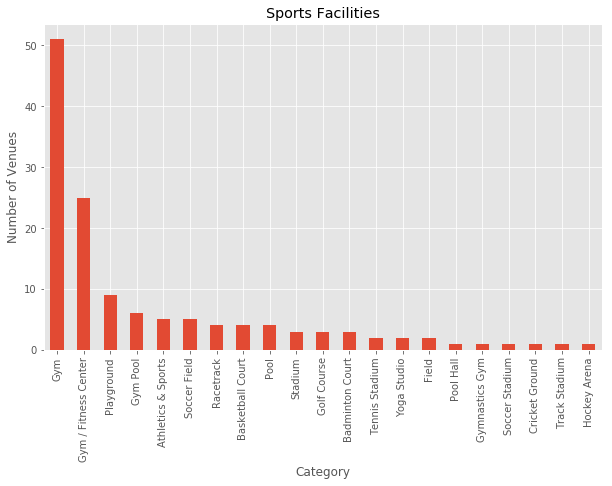

In [234]:
#  plot data
category_count_sorted = category_count.sort_values('Count', ascending=False)
category_count_sorted.plot(kind='bar', figsize=(10, 6), legend = None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Sports Facilities') # add title to the plot

plt.show()

Wordcloud is installed and imported!
Word cloud created!


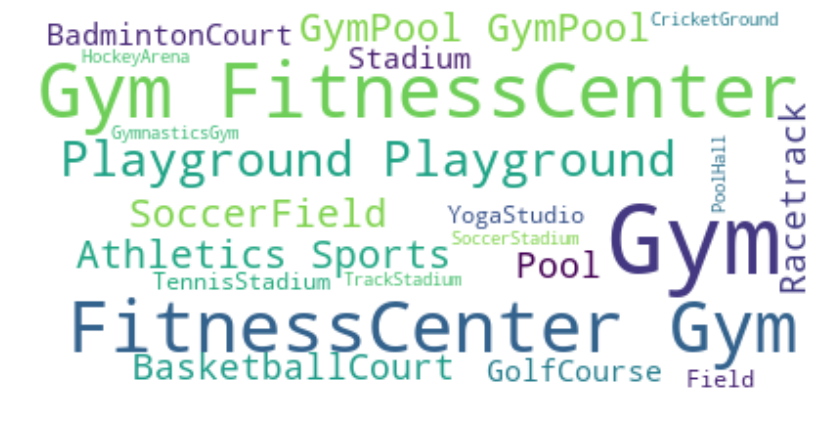

In [224]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

stopwords = set(STOPWORDS)

max_words = 90
word_string = ''
for category in category_count.index.values:
       #print(category_count.loc[category_count['Count']])
        repeat_num_times = int(category_count.loc[category, 'Count'])
        word_string = word_string + ((category.replace(" ", "") + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [239]:
#neighborhoods.loc[neighborhood['Ward'] == 'Dayananda Nagar']
blore_venues_display = blore_venues.loc[blore_venues['Ward'] == 'Agaram',:]
blore_venues_display

Ward  Ward Latitude  Ward Longitude                           Venue  \
1907  Agaram      12.944263       77.639047                Ministry of Food   
1908  Agaram      12.944263       77.639047     Hilton Bangalore Residences   
1909  Agaram      12.944263       77.639047         California Burrito, EGL   
1910  Agaram      12.944263       77.639047                      Love Shack   
1911  Agaram      12.944263       77.639047                    Mother Earth   
1912  Agaram      12.944263       77.639047                  Domino's Pizza   
1913  Agaram      12.944263       77.639047             Origin Espresso Bar   
1914  Agaram      12.944263       77.639047                       Tea Mount   
1915  Agaram      12.944263       77.639047                          Subway   
1916  Agaram      12.944263       77.639047                 Cafe Coffee Day   
1917  Agaram      12.944263       77.639047                             KFC   
1918  Agaram      12.944263       77.639047              Pyramid Food Court   
1919  Agaram      12.944263       77.639047                [24]7 Food Court   
1920  Agaram      12.944263       77.639047                      Kaati Zone   
1921  Agaram      12.944263       77.639047                          Adigas   
1922  Agaram      12.944263       77.639047                   Beijing Bites   
1923  Agaram      12.944263       77.639047                       Loveshack   
1924  Agaram      12.944263       77.639047  Au Bon Pain Cafe India Limited   
1925  Agaram      12.944263       77.639047                     Au Bon Pain   
1926  Agaram      12.944263       77.639047        Intel Security Cafeteria   
1927  Agaram      12.944263       77.639047                           Klinx   
1928  Agaram      12.944263       77.639047                  Ejipura Signal   
1929  Agaram      12.944263       77.639047                       Rice Momo   
1930  Agaram      12.944263       77.639047                    Urban Ladder   

      Venue Latitude  Venue Longitude          Venue Category  Sports_Venue  
1907       12.948475        77.645516              Restaurant             0  
1908       12.948375        77.645682                   Hotel             0  
1909       12.949113        77.644034      Mexican Restaurant             0  
1910       12.952540        77.640314                  Lounge             0  
1911       12.952491        77.640259  Furniture / Home Store             0  
1912       12.949283        77.643755             Pizza Place             0  
1913       12.949896        77.642335             Coffee Shop             0  
1914       12.949005        77.643883                Tea Room             0  
1915       12.949065        77.643942          Sandwich Place             0  
1916       12.952180        77.640242                    Café             0  
1917       12.949086        77.643835    Fast Food Restaurant             0  
1918       12.949063        77.644009              Food Court             0  
1919       12.946924        77.645314              Food Court             0  
1920       12.949189        77.643747       Indian Restaurant             0  
1921       12.949234        77.643794       Indian Restaurant             0  
1922       12.949244        77.643827      Chinese Restaurant             0  
1923       12.952692        77.640193                  Lounge             0  
1924       12.946229        77.646446                    Café             0  
1925       12.945801        77.646604                    Café             0  
1926       12.946524        77.646523               Cafeteria             0  
1927       12.948636        77.645615                  Lounge             0  
1928       12.938640        77.632506            Intersection             0  
1929       12.943912        77.630296      Chinese Restaurant             0  
1930       12.952645        77.640970  Furniture / Home Store             0